# **Instalación de librerias**

In [1]:
!pip install torchsummary
!pip install torchmetrics
!pip install torchvision
!pip install opencv-python
!pip install fxpmath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fxpmath: filename=fxpmath-0.4.9-py3-none-any.whl size=35223 sha256=4d473ed5fa757b93899d09a67a7412725b5da94ef68d8ad564b725264d150ab3
  Stored in directory: /tmp/pip-ephem-wheel-cache-6rju9y3p/wheels/4a/75/f7/65a895cb07af2c0c9590a063373ade5b7215f26198c3704574
Successfully built fxpmath


In [2]:
!pip install torchvision

# **Simulated Annealing o Recocido Simulado**

El algoritmo de Recocido Simulado (*Simulated Annealing*) viene del mundo de la metalurgia, en el que cuando se funde un metal hay que dejar que este se enfrie lentamente para obtener un buen resultado. Por tanto, esto se tradujó al mundo de la algoritmia en el que para buscar la solución óptima en un problema donde el espacio muestral es grande y desconocido, presenta muy buenos resultados.

## **Algoritmo**

Imaginandonos el siguiente imagen como el espacio muestral que queremos optimizar, este caso, buscando el máximo de la función. Es muy dificil encontrar a veces el máximo global (***GM, global maximum***) ya que nos podriamos estancar en un máximo local.

 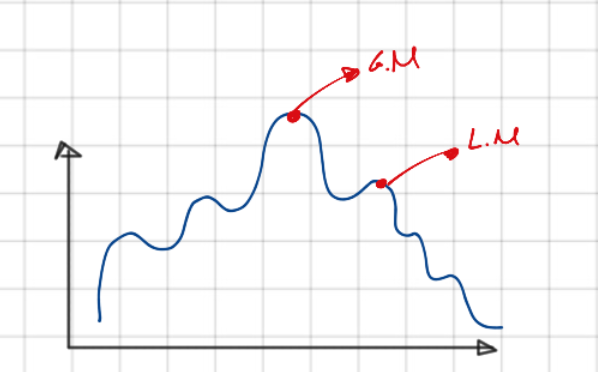

Por tanto, inicialmente en el algoritmo se busca un estado inicial que s eescoge de manera al azar y se establece un valor máximo y mínimo de temperatura del modelo.

Una vez arrancamos el algoritmo:
* 1- se evalua el coste del modelo en el estado actual, donde el coste es una función escogida, que permita evaluar el estado.
* 2- se calcula el siguiente vecino, es decir, el siguiente posible estado. La busqueda de este nuevo estado se calcula de maneras diferentes dependiendo del problema que se quiera resolver, pero en todos los casos, este calculco de busqueda del vecino depende directamente de la Temperatura que tenga el modelo en dicho momento. A mayor temperatura, la busqueda de este vecino es más aleatorio, es decir, puede que este más lejos, pero, en caso de que se vaya enfriando la temperatura (como en el problema de la metalurgia) este vecino cada vez es más cerco al estado anterior, convergiendo así el problema.
* 3- Una vez obtenido este vecino, se calcula el coste que supone estar en este nuevo estado
* 4- Con el coste del nuevo vecino y el anterior, se les calcula la diferencia, y si el nuevo coste es mejor, inferior, al anterior, se acepta este nuevo estado. Pero en caso de que no sea una mejor solución este nuevo estado solo es aceptado en el caso de que se cumpla la siguiente condición $e^{(\Delta E/T)}>rand(0,1)$.

  Por tanto, en el caso de que estamos en un caso peor, esto se aceptará solo en el caso de que se cumpla la condición anterior. Es decir, en el momento en el que dicha expresión sea mayor al valor aleatorio de $rand(0,,1)$, que esto se cumple con más facilidad al principio del algoritmo en el momento en el que $\Delta E<0$ y la $T$ es muy alta, resultado en un valor de $e^{(\Delta E/T)}$ muy cercano a 1, por tanto hay altas probabilidades de que sea mayor al valor aleatorio de rand(0,1) y se acepte este nueve estado, aunque sea peor, pero esto puede evitar que nos estanquemos en un máximo local. Mientras que por otro lado, en el caso de que  $\Delta E<0$ y la $T$ es baja, el valor resultante de $e^{(\Delta E/T)}$ este es muy bajo, cercano a 0 y tiene más complicado que se acepte este nuevo estado.

## **Algoritmo de optimización de cuantización**

En nuestro caso, tenemos como objetivo la optimizacion del tamaño del modelo mediante la cuantización de la parte fraccionaria de los pesos y activaciones del modelo. 

Muchas veces, en los modelos de Machine Learning, tenemos una precisión de 32 bits por el tipo de diseño que tienen las librerías, pero a veces es innecesario tener tanta precisión en los pesos y sesgos del modelo. En algunas capas, con precisiones inferiores podemos obtener mismas métricas del modelo o incluso podemos aceptar tener un modelo ligeramente peor pero con el fin de tener un modelo mucho más pequeño en cuanto a temas de almacenamiento.
para ciertas operaciones ya que el resultado final es el mismo, o ligeramente inferior, pero con esto conseguimos reducir el tamaño del modelo significativamente. Con esto podemos obtener modelos ligeros y que son manejables por dispositvos con recursos limitado. En nuestro caso, nos permite la implementación de estos modelos en FPGAs.

En nuestro caso, el algoritmo utilizado sigue lo mismmo explicado anteriormente, pero la función de coste realizada es la siguiente: 
$$coste=\gamma*((lower bound-mAP50)**2) + \beta*avg bits -\alpha*lower bound + \Omega*total_{loss}$$
Donde se pueden especificar los valores de $\gamma(=1)$, $\alpha(=0.5)$, $\beta(=50)$, entre paréntesis, se especifican de momento los valores predeterminados. 

En el código que nos encontramos en ***simulated_annealing.py*** hay una serie de parámetros que podemos modificar, que se tienen que realizar directamente desde ahí. Donde podemos ver los parámetros:
* simulations = 1 -> este parámetro nos permite realizar varias simulaciones del algorítmo varias veces que permite analizar posibles convergencias del modelo. Con varias simulaciones nos permite extraer métricas como la varianza y media como resultante de la optimización de la cuantización de los pesos y activaciones
* Max_steps = 100 -> el número de epocas del algoritmo de convergencia. Da igual el número de epocas que pongamos, que el algoritmo siempre converge hacia una solución.
* interval = (4, 18,) -> intervalo de los valores en los que queremos que nuestro modelo busque los diferentes niveles de cuantización para cada capa de manera aleatoria
* max_degradation = 5 -> la máximas degradación que estamos dispuestos a aceptar del modelo, de la métrica de coste
* alpha = 0.1 -> Parámetro de la función de coste 
* beta = 10 -> Parámetro de la función de coste
* gamma = 2 -> Parámetro de la función de coste

Esta selección de las constantes puede variar en función del problema y la importancia que le queramos dar a estas penalizaciones

Independientemente de esta configuración, también dependemos del fichero de ***config.py*** para la seleccción del modelo.

En la subcarpeta del modelo ***model_opt*** se encuentran las diferentes pruebas realizadas, y el modelo de optimización obtenido con dicha precisión, por si luego se quuieren hacer pruebas de ruido y de predicciones.

# **Como escoger los rangos**

Para poder escoger de manera óptima el rango que necesitamos para la optimización del nímero de bits de la parte fraccionaria, se genera un script ejecutando el siguiente código en el que se genera un script dentro de la carpeta de ***model_opt*** que se llama ***range_bits.txt*** en el que se observa el rango minimo y máximo que se puede tomar en cada capaz en función del número de bits que se necesitaría para representar cada capa.

Hay dos códigos  **simulated_annealing_FullPipeline.py** y **simulated_annealing_Slices.py**, para el primer caso se realiza la búsqeuda óptima a lo largo de todo el modelo, mientras que para el caso del segundo, dividimos el pipeline de la arquitectura en N y se realiza el proceso del simmulated annealing en cada uno de los N trozos.

Se observa que para un límite de rango de bits con un limite inferior, converge mejor a una solución óptima, cuanto más slices hay.

In [5]:
!python simulated_annealing_Slices.py

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
##############################################################
              Simulation 1 of 1         
##############################################################
Traceback (most recent call last):
  File "/home/jovyan/Carlos_Gonzalez/YOLO/simulated_annealing_Slices.py", line 151, in <module>
    model, optimizer = load_model()
                       ^^^^^^^^^^^^
  File "/home/jovyan/Carlos_Gonzalez/YOLO/simulated_annealing_Slices.py", line 96, in load_model
    best_model, epoch_best_model = find_the_best_model(os.path.join(config.DRIVE_PATH,f'{config.BACKBONE}/{config.TOTAL_PATH}/model'))
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovy

In [ ]:
!python train.py

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(

Model Configuration Summary:
  Dataset: Airbus_256
  Backbone: efficientnet (Pretrained)
  Batch Size: 32
  Optimizer: 2NAdam
  Learning Rate Scheduler: None
  Number of Classes: 1
  Image Size: 224
Summary saved to /home/jovyan/Carlos_Gonzalez/YOLO/efficientnet/2NAdam_None_Airbus_256_BATCH_32_LR_0.0005/model_summary.txt
efficientnet | Parameters: 35385047 | Size: 135.26 MB
Epoch [0/59]: 100%|█████████████████| 329/329 [00:46<00:00,  7.09it/s, loss=313]
---------------------------------------------------
-----------Loss Summary during training------------
Total Loss  |Loss Coord  |Conf Loss   |No Obj Loss |Class Loss  |
466.153     |91.134      |18.457      |45.732      |3.895       |
---------------------------------------------------
Eval: Tr

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch [27/59]: 100%|███████████████| 329/329 [00:43<00:00,  7.58it/s, loss=33.6]
---------------------------------------------------
-----------Loss Summary during training------------
Total Loss  |Loss Coord  |Conf Loss   |No Obj Loss |Class Loss  |
31.290      |11.925      |7.293       |4.112       |0.239       |
---------------------------------------------------
Eval: Train: : 100%|██████████████████████████| 330/330 [00:53<00:00,  6.15it/s]
---------------------------------------------------
-------------Loss Summary eval {mode}--------------
Total Loss  |Loss Coord  |Conf Loss   |No Obj Loss |Class Loss  |
16.733      |8.285       |6.143       |2.336       |0.179       |
---------------------------------------------------
Train: 	 mAP@50: 0.634848, mAP@75: 0.368401, mAP@90: 0.012614, Mean Loss: 16.732799
Eval: Valid: : 100%|████████████████████████████| 92/92 [00:10<00:00,  8.69it/s]
---------------------------------------------------
-------------Loss Summary eval {mode}--------